# Sentiment Analysis with BERT

> In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!



## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [2]:
#@title Setup & Config
import transformers
from transformers import DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Behnam\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\Behnam\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [148]:
df = pd.read_csv("reviews.csv")
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [149]:
df.shape

(15746, 11)

### Let's work with smaller dataframe

In [150]:
df = df.sample(frac = 0.1, random_state = 22)
df.reset_index(drop=True, inplace=True)

df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Garrett Dally,https://lh3.googleusercontent.com/-ZYfR0zlbpIA...,It's fun and easy to use.,5,0,2.4.3,2020-02-13 22:16:54,NaN,NaN,newest,com.habitrpg.android.habitica
1,A Google user,https://lh3.googleusercontent.com/EGemoI2NTXmT...,you basically can't do anything if you don't b...,2,0,NaN,2019-03-10 06:20:13,"Unfortunately, this is not true. There are onl...",2019-03-10 07:38:58,newest,com.gmail.jmartindev.timetune
2,Jenni Kmiotek,https://lh3.googleusercontent.com/a-/AOh14GjTv...,"It's fun, a great concept, but the app itself ...",3,4,2.4.4,2020-02-29 04:44:56,"Hi Jenni, sorry to hear about the trouble. If ...",2020-03-13 17:53:31,most_relevant,com.habitrpg.android.habitica
3,Kathleen Case,https://lh3.googleusercontent.com/a-/AOh14GiRd...,"Moved here from Wunderlist, after trying other...",5,1,15.4.0,2020-03-29 03:42:12,NaN,NaN,most_relevant,com.todoist
4,Sai Vemuri,https://lh3.googleusercontent.com/a-/AOh14GhU0...,"Of all the things that this app does great, it...",3,0,NaN,2018-09-08 04:29:39,NaN,NaN,newest,com.oristats.habitbull


We have about 1,5K examples. Let's check for missing values:

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575 entries, 0 to 1574
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              1575 non-null   object
 1   userImage             1575 non-null   object
 2   content               1575 non-null   object
 3   score                 1575 non-null   int64 
 4   thumbsUpCount         1575 non-null   int64 
 5   reviewCreatedVersion  1349 non-null   object
 6   at                    1575 non-null   object
 7   replyContent          724 non-null    object
 8   repliedAt             724 non-null    object
 9   sortOrder             1575 non-null   object
 10  appId                 1575 non-null   object
dtypes: int64(2), object(9)
memory usage: 135.5+ KB


Great, no missing values in the score and review texts! Do we have class imbalance?

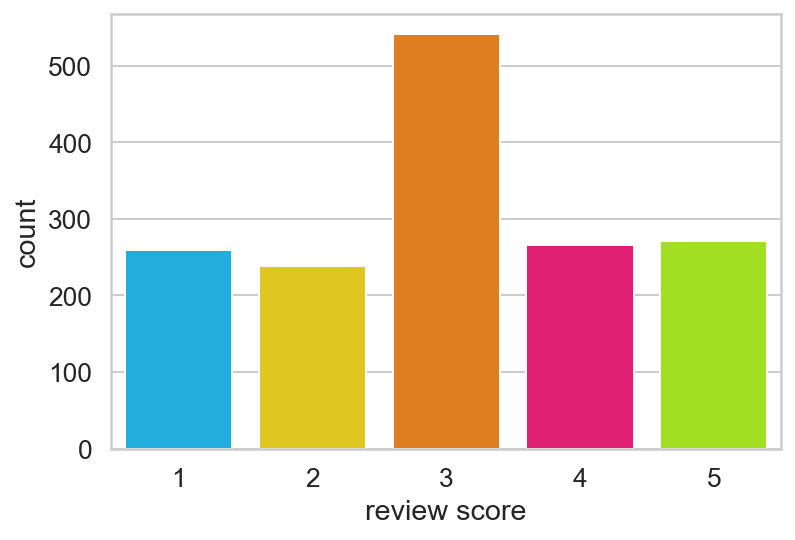

In [152]:
sns.countplot(df.score)
plt.xlabel('review score');

That's hugely imbalanced, but it's okay. We're going to convert the dataset into negative, neutral and positive sentiment:

In [153]:
df['sentiment'] = df.score.apply(lambda x: 0 if x <= 2 else 1 if x == 3 else 2)
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Garrett Dally,https://lh3.googleusercontent.com/-ZYfR0zlbpIA...,It's fun and easy to use.,5,0,2.4.3,2020-02-13 22:16:54,NaN,NaN,newest,com.habitrpg.android.habitica,2
1,A Google user,https://lh3.googleusercontent.com/EGemoI2NTXmT...,you basically can't do anything if you don't b...,2,0,NaN,2019-03-10 06:20:13,"Unfortunately, this is not true. There are onl...",2019-03-10 07:38:58,newest,com.gmail.jmartindev.timetune,0
2,Jenni Kmiotek,https://lh3.googleusercontent.com/a-/AOh14GjTv...,"It's fun, a great concept, but the app itself ...",3,4,2.4.4,2020-02-29 04:44:56,"Hi Jenni, sorry to hear about the trouble. If ...",2020-03-13 17:53:31,most_relevant,com.habitrpg.android.habitica,1
3,Kathleen Case,https://lh3.googleusercontent.com/a-/AOh14GiRd...,"Moved here from Wunderlist, after trying other...",5,1,15.4.0,2020-03-29 03:42:12,NaN,NaN,most_relevant,com.todoist,2
4,Sai Vemuri,https://lh3.googleusercontent.com/a-/AOh14GhU0...,"Of all the things that this app does great, it...",3,0,NaN,2018-09-08 04:29:39,NaN,NaN,newest,com.oristats.habitbull,1


In [154]:
df.sentiment.value_counts()

1    541
2    537
0    497
Name: sentiment, dtype: int64

In [155]:
class_names = ['negative', 'neutral', 'positive']

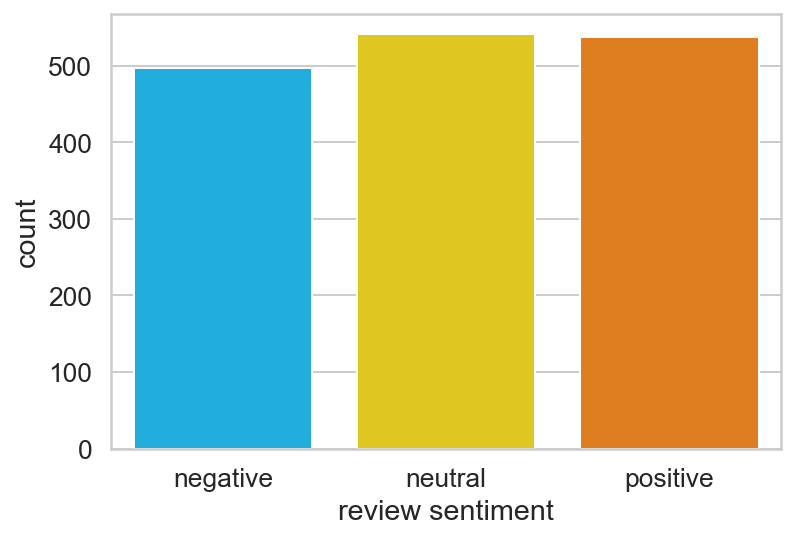

In [156]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [157]:
PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [DistilBertTokenizer](https://huggingface.co/transformers/model_doc/distilbert.html):

In [158]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

We'll use this text to understand the tokenization process:

In [159]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [160]:
tokens = tokenizer.tokenize(sample_txt )
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [161]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [162]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [163]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [164]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [165]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [166]:
encoding

{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

The token ids are now stored in a Tensor and padded to a length of the longest sample:

In [167]:
print(encoding['input_ids'].shape)
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

torch.Size([1, 32])
32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:
- Because we have only one sentence, attention mask is all 1

In [168]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [169]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [170]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))
    

In [171]:
# total number of tokens
len(token_lens)

1575

and plot the distribution:

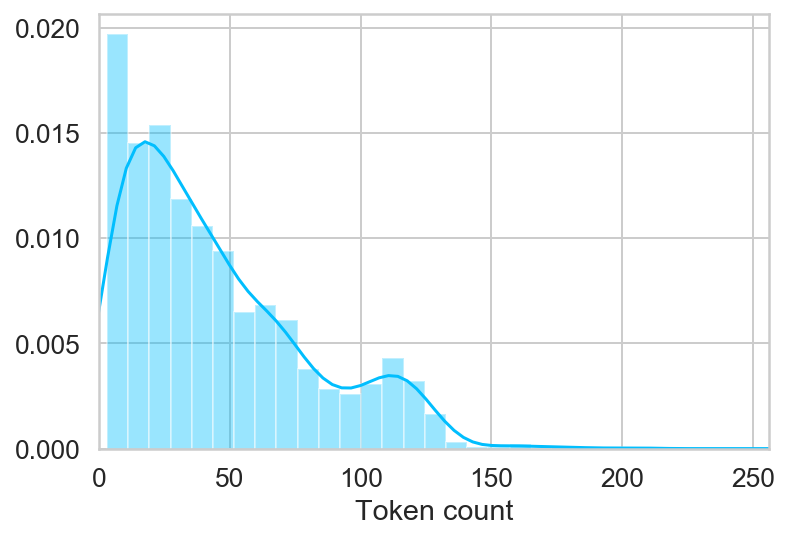

In [172]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [173]:
# MAX_LEN = 160

In [174]:
import torch
from torch.utils.data import Dataset

class make_dataset(Dataset):
    def __init__(self, df):
        self.X = df.content # Series
        y = df.sentiment.values # scalaer values
        self.y = torch.tensor(y, dtype = torch.float32) # these are 0, 1 or 2 floats
        
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
        #max_len = 1110
        self.encoding = self.X.apply(lambda l: self.tokenizer.encode_plus(
                  l,
                  add_special_tokens=True,
                  max_length= 64,
                  return_token_type_ids=False,
                  padding='max_length',
                  return_attention_mask=True,
                  return_tensors='pt',
                  truncation=True)
                )

        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):    
        return self.encoding[idx] ,self.y[idx]


In [176]:
df_test.content

1194    I used to use Habitica, and I must say this is...
1278    Okay better than others but the design should ...
1129    If more than one task is enabled for same time...
488                  Completed tasks continue to reappear
1171    I'd really like to use this app, but there's n...
                              ...                        
969     Love the way it can be easily zoomed for both ...
41                                             Quite good
15      I tried out this app but decided not to go wit...
158     I love it, simple and effective! Is it right t...
1238    Demands premium account for serving the most b...
Name: content, Length: 473, dtype: object

In [188]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=2, stratify = df.sentiment)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_test = df.sample(frac = 0.3, random_state = 22)
df_test.reset_index(drop=True, inplace=True)

In [189]:
train_data = make_dataset(df_train)
test_data = make_dataset(df_test)

In [190]:
df_train.shape,  df_test.shape

((1102, 12), (473, 12))

In [191]:
len(train_data), len(test_data)

(1102, 473)

In [194]:
train_data[:5], test_data[:5]

((0    [input_ids, attention_mask]
  1    [input_ids, attention_mask]
  2    [input_ids, attention_mask]
  3    [input_ids, attention_mask]
  4    [input_ids, attention_mask]
  Name: content, dtype: object, tensor([2., 2., 2., 0., 2.])),
 (0    [input_ids, attention_mask]
  1    [input_ids, attention_mask]
  2    [input_ids, attention_mask]
  3    [input_ids, attention_mask]
  4    [input_ids, attention_mask]
  Name: content, dtype: object, tensor([1., 1., 1., 1., 0.])))

In [195]:
train_data[0]

({'input_ids': tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
            119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
            117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}, tensor(2.))

In [196]:
train_data[0][0]

{'input_ids': tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
           119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
           117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [197]:
train_data[0][0]['input_ids'].squeeze() 
# we need to get rid of one additional dimension in tokenized sentences

tensor([  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
          119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
          117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [198]:
print(len(train_data[0][0]['input_ids'].squeeze()))
train_data[0]

64


({'input_ids': tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
            119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
            117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}, tensor(2.))

In [199]:
train_data[0][0]

{'input_ids': tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
           119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
           117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [200]:
train_data[0][1]

tensor(2.)

In [201]:
train_data[2:5][0].values

array([{'input_ids': tensor([[  101,  6424, 13156,  1111,  1208,   119,   119,   119, 16602,  1111,
          1103,  1263,  1858,  2686,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])},
       {'input_ids': tensor([[  101,   146,  1328,  1106,  2561,   170,  2366,  6030,  1105,  1129,
          1682,  1106,  1821,  6696,  1551,  1111,  2366,  2619,  1113,  1103,
          7957,  1989,   119,  7595,   117,  

In [202]:
# a tuple of a diuctionary and a tensor
train_data[3]

({'input_ids': tensor([[  101,   146,  1328,  1106,  2561,   170,  2366,  6030,  1105,  1129,
           1682,  1106,  1821,  6696,  1551,  1111,  2366,  2619,  1113,  1103,
           7957,  1989,   119,  7595,   117,  1165,  1128,  1821,  6696,  1103,
           1159,  1517,  1122,  2607,  1240,  6030,  2423,   119,   142, 17243,
           1942,   118,   146,  8856,  1103,  2593,  1105,  1350,  1120,  1103,
           6388,   119,   146,  1274,   112,   189,  1328,  1106,  1138,  1106,
           2561,   170,  2006,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, tensor(0.))

In [203]:
# values of the sieries
train_data[:3][0]

0    [input_ids, attention_mask]
1    [input_ids, attention_mask]
2    [input_ids, attention_mask]
Name: content, dtype: object

In [204]:
type(train_data[:5][1])

torch.Tensor

### each element in train_data is a tuple consists of a dictionary and a tensor
### each dictionary has 2 keys of 'input_ids', 'attention_mask' 


In [205]:
train_data[0] # a tuple of a dictionary and a tensor

({'input_ids': tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
            119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
            117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}, tensor(2.))

In [206]:
print(type(train_data[0][0])) # a dictionary with keys 'input_ids', 'attention_mask' 
train_data[0][0]['input_ids']

<class 'transformers.tokenization_utils_base.BatchEncoding'>


tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
           119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
           117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])

In [207]:
print(type(train_data[0][1])) # a dictionary with keys 'input_ids', 'attention_mask'
train_data[6][0]['input_ids']

<class 'torch.Tensor'>


tensor([[ 101, 6424, 5616, 8729, 1111, 1234, 1107, 1671, 1105, 1256, 1111, 5116,
         2833,  119,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])

In [208]:
print(type(train_data[0][1]))
train_data[:5][1]

<class 'torch.Tensor'>


tensor([2., 2., 2., 0., 2.])

In [209]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 15, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, drop_last=True)

In [210]:
test_data = next(iter(test_loader))
print(type(test_data)) # a list of 2 elemenets one dictionary and one tensor
print(test_data[0]['input_ids'].squeeze(1).shape)
print(test_data[0]['attention_mask'].squeeze(1).shape)
print(test_data[1].shape)

<class 'list'>
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32])


Let's have a look at an example batch from our training data loader:

In [211]:
data = next(iter(train_loader))
print(type(data)) # a list of 2 elemenets one dictionary and one tensor
data

<class 'list'>


[{'input_ids': tensor([[[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
              119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
              117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
                0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                0,     0,     0,     0]],
  
          [[  101, 12167,  1106, 11896,  5086,  4948,  1114,  3014,  4579,  7758,
             1105,  6026,  1104,  4579,   119, 26456,  1104, 15225,  1880,   119,
              146,  1176,  1122,  1177,  1677,   119,   102,     0,     0,     0,
                0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
                0,     0,     0,     0, 

In [212]:
len(data)

2

In [213]:
# a dictionary of input_ids and attention_mask
data[0]

{'input_ids': tensor([[[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
             119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
             117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0]],
 
         [[  101, 12167,  1106, 11896,  5086,  4948,  1114,  3014,  4579,  7758,
            1105,  6026,  1104,  4579,   119, 26456,  1104, 15225,  1880,   119,
             146,  1176,  1122,  1177,  1677,   119,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0, 

In [214]:
#
inp_ids = data[0]['input_ids'].squeeze(1)
print(inp_ids.shape)
inp_ids

torch.Size([15, 64])


tensor([[  101, 17067,  1158,   119,   119,   119,   119,   146,  1341,   119,
           119,   119,  1753,  1870,  2222,   119, 11050,  1303, 25600,  2603,
           117,  1105, 22436,   170,  2780,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101, 12167,  1106, 11896,  5086,  4948,  1114,  3014,  4579,  7758,
          1105,  6026,  1104,  4579,   119, 26456,  1104, 15225,  1880,   119,
           146,  1176,  1122,  1177,  1677,   119,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0

In [215]:
print(data[0]['input_ids'].shape)
att_mask = data[0]['input_ids'].squeeze(1)
att_mask.shape

torch.Size([15, 1, 64])


torch.Size([15, 64])

In [216]:
print(data[0]['input_ids'].squeeze(1).shape)
print(data[0]['attention_mask'].squeeze(1).shape)
print(data[1].shape)

torch.Size([15, 64])
torch.Size([15, 64])
torch.Size([15])


In [217]:
test_data = next(iter(test_loader))
print(type(test_data)) # a list of 2 elemenets one dictionary and one tensor
print(test_data[0]['input_ids'].squeeze(1).shape)
print(test_data[0]['attention_mask'].squeeze(1).shape)
print(test_data[1].shape)

<class 'list'>
torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [218]:
bert_model = transformers.DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [219]:
type(inp_ids)

torch.Tensor

In [220]:
last_hidden_state = bert_model(
  input_ids=inp_ids, 
  attention_mask=att_mask
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [221]:
# hidden states of all 64 tokens
last_hidden_state[0].shape

torch.Size([15, 64, 768])

In [222]:
# value of the CLS token is our desired hidden state of the mdoel
last_hidden_state[0][:, 0, :].shape

torch.Size([15, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [223]:
bert_model.config.hidden_size

768

We can use all of this knowledge to create a classifier that uses the BERT model:

In [224]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes=3):
    super().__init__()
    self.bert = transformers.DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    hidden_states = self.bert(
    input_ids=input_ids,
    attention_mask=attention_mask)
    
    cls_output = hidden_states[0][:, 0, :] # hidden state of cls token only
    output = self.drop(cls_output)
    return self.out(output) # raw ouput for multi-class classification

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [239]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [226]:
inp_ids = inp_ids.to(device)
att_mask = att_mask.to(device)

print(inp_ids.shape) # batch size x seq length
print(att_mask.shape) # batch size x seq length

torch.Size([15, 64])
torch.Size([15, 64])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [227]:
F.softmax(model(inp_ids, att_mask), dim=1)

tensor([[0.2085, 0.4355, 0.3560],
        [0.2210, 0.4210, 0.3580],
        [0.2773, 0.3706, 0.3521],
        [0.2040, 0.5136, 0.2824],
        [0.2348, 0.4039, 0.3613],
        [0.3351, 0.3844, 0.2805],
        [0.2148, 0.4278, 0.3574],
        [0.1814, 0.3277, 0.4910],
        [0.2260, 0.3369, 0.4371],
        [0.2641, 0.3536, 0.3823],
        [0.2343, 0.4120, 0.3538],
        [0.1681, 0.4157, 0.4162],
        [0.2530, 0.3154, 0.4316],
        [0.1995, 0.3798, 0.4206],
        [0.2371, 0.3855, 0.3775]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [240]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
criterion = nn.CrossEntropyLoss().to(device) # CrossEntropyLoss has Softmax inside it

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [229]:
#device = 'cpu'

In [234]:
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  n_examples):
    
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    
    input_ids = d[0]['input_ids'].squeeze(1).to(device)
    attention_mask = d[0]['attention_mask'].squeeze(1).to(device)
    targets = d[1].to(dtype=torch.long).to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1) # multi class classification
    #print(f"train: {preds, targets}")
    loss = criterion(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [235]:
def eval_model(model, data_loader, criterion, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
        
        input_ids = d[0]['input_ids'].squeeze(1).to(device)
        attention_mask = d[0]['attention_mask'].squeeze(1).to(device)
        targets = d[1].to(dtype=torch.long).to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1) # preds is the index of the max values (equal to target)

        loss = criterion(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [236]:
len(df_train), len(df_test)

(1102, 473)

In [241]:
%%time
EPOCHS = 10

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    model,
    train_loader,    
    criterion, 
    optimizer, 
    device, 
    len(df_train)
  )

  
    val_acc, val_loss = eval_model(
    model,
    test_loader,
    criterion, 
    device, 
    len(df_test)
  )

    print(f'Train loss {train_loss:0.3f} accuracy {train_acc:0.3f}')

    print(f'Val   loss {val_loss:0.3f} accuracy {val_acc:0.3f}')
    print()


Epoch 1/10
----------
Train loss 0.976 accuracy 0.493
Val   loss 0.827 accuracy 0.567

Epoch 2/10
----------
Train loss 0.655 accuracy 0.724
Val   loss 0.797 accuracy 0.592

Epoch 3/10
----------
Train loss 0.379 accuracy 0.857
Val   loss 1.038 accuracy 0.596

Epoch 4/10
----------
Train loss 0.170 accuracy 0.936
Val   loss 1.686 accuracy 0.581

Epoch 5/10
----------
Train loss 0.138 accuracy 0.956
Val   loss 1.708 accuracy 0.609

Epoch 6/10
----------
Train loss 0.043 accuracy 0.984
Val   loss 2.041 accuracy 0.609

Epoch 7/10
----------
Train loss 0.028 accuracy 0.986
Val   loss 2.387 accuracy 0.588

Epoch 8/10
----------
Train loss 0.021 accuracy 0.985
Val   loss 2.387 accuracy 0.605

Epoch 9/10
----------
Train loss 0.021 accuracy 0.986
Val   loss 2.401 accuracy 0.605

Epoch 10/10
----------
Train loss 0.014 accuracy 0.986
Val   loss 2.574 accuracy 0.598

Wall time: 5min 4s


### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')